## Define the class for SCSC algorithm

In [3]:
import numpy as np
import matplotlib.pyplot as plt
plt.rcParams.update({
    "text.usetex": True,
    "font.family": "sans-serif",
    "font.sans-serif": ["Helvetica"],
    "ps.usedistiller": "xpdf"})


class SoR:
    """ parrent class for SOR algorithms, based on the risk-averse of quadratic function, provide function and gradient estimators for this specific problem

    Attributes:
        A: samples of A_xi
        batch_size: batch size for inner and outer function value/gradient samples

    """

    def __init__(self,  A, batch_size):
        self.A = A
        self.batch_size = batch_size

        self.d = A.shape[0]
        self.n = A.shape[2]  #
        self.A_avg = self.A.mean(axis=2)

    def _sample_A(self):
        # sample the A mattrix
        idx_sample = np.random.randint(0, self.n, self.batch_size)
        return self.A[:, :, idx_sample]

    def _get_val_g(self, A_sample, x):
        # get sample value of inner function g
        g1 = 1/2 * x.T @ np.mean(A_sample, 2) @ x
        g2 = 1/2 * np.einsum('j, ijk, i', x, A_sample, x)
        g2 = np.mean(g2**2)

        return np.array([g1, g2])  # g value

    def _get_val_F(self, x):
        # get deterministic function value at x
        temp = np.einsum('j,ijk,i', x, self.A, x)
        temp = np.mean(temp**2)

        return -1/2 * x.T @ self.A_avg @ x + self.lmbda*(temp - 1/4*(x.T @ self.A_avg @ x)**2)

    def _get_grad_h(self, x):
        # get gradient of geneartining function h(x)
        return self.k1 * x + self.k2 * np.linalg.norm(x)**2 * x

    def _get_grad_g(self, A_sample, x):
        # get sample gradient of inner function g
        grad_g1 = np.einsum('ijk,j->ik', A_sample, x)
        grad_g21 = np.einsum('j,ijk,i', x, A_sample, x)
        grad_g2 = grad_g21 * grad_g1

        return np.row_stack([grad_g1.mean(axis=1), grad_g2.mean(axis=1)])

    def _get_grad_f(self, u):
        # get gradient of outter function f(which is deterministic )
        return np.array([-1 - 2 * self.lmbda * u[0], self.lmbda])

####################################


class SCSC_SoR(SoR):
    """
    SCSC method for SoR problem

    Attributes:
        A: samples of A_xi
        batch_size: batch size for inner and outer function value/gradient samples
        max_iter: maximum iteration number of the algorithm
        x_init: initial x
        tau: step size
        beta: moving average coef
        R: radius of feasible set
        d: length of variable x
        n: number of samples of A_xi
        A_avg: E[A_xi]

    Result Attributes:
        x_traj: trajectory of x
        x_hat_traj: trajectory of x_hat
        val_F_traj: trajectory of deterministic function value
        Dh1_x_hat, Dh2_x_hat: D_h(x_hat^{k+1}, x_hat^k)
        Dh1_x_hat_avg, Dh1_x_hat_avg: 1/k sum_0^k D_h(x_hat^{k+1}, x_hat^k)


    """

    def __init__(self,  A, batch_size, x_init, tau, beta, max_iter, R, lmbda=1):
        super().__init__(A, batch_size)
        self.max_iter = max_iter
        self.x_init = x_init  # initial x
        self.tau = tau
        self.beta = beta
        self.lmbda = lmbda
        self.R = R

        self.x_traj = np.zeros([self.d, self.max_iter])  # traj of x
        # traj of x_hat(calculated based on determinastic function)
        self.x_hat_traj = np.zeros([self.d, self.max_iter])
        self.x_hat_avg_traj = np.zeros([self.d, self.max_iter])
        # traj of determinastic function value
        self.val_F_traj = np.zeros(self.max_iter)
        # D_h1(x_hat^{k+1}- x_hat^k) with tau and k1
        self.Dh1_x_hat = []
        # D_h2(x_hat^{k+1}- x_hat^k) with tau and k2
        self.Dh2_x_hat = []
        # average of all previous iterations
        self.Dh1_x_hat_avg = []
        self.Dh2_x_hat_avg = []

    def _projectd_gradient_step(self, x, w):
        # gradient step
        y = x - self.tau * w
        # projection
        y = y * min(1, self.R/np.linalg.norm(y))
        return y

    def _update_u(self, A_sample, u, x_pre, x):
        g_pre = self._get_val_g(A_sample, x_pre)
        g = self._get_val_g(A_sample, x)

        u = (1 - self.beta) * (u + g - g_pre) + self.beta * g

        return u

    def train(self):
        x = self.x_init

        # initial sample
        A_sample = self._sample_A()
        u = self._get_val_g(A_sample, x)
        v = self._get_grad_g(A_sample, x)
        s = self._get_grad_f(u)
        w = v.T @ s

        w = np.random.randn(self.d)
        u = np.random.randn(2)



        for iter in range(self.max_iter):
            x_pre = x
            x = self._projectd_gradient_step(x, w)

            A_sample = self._sample_A()
            u = self._update_u(A_sample, u, x_pre, x)
            v = self._get_grad_g(A_sample, x)
            s = self._get_grad_f(u)
            w = v.T @ s

            self.x_traj[:, iter] = x

            # calculate x_hat
            val_g = self._get_val_g(self.A, x)
            v_det = self._get_grad_g(self.A, x)
            s_det = self._get_grad_f(val_g)
            grad_F = v_det.T @ s_det
            x_hat = self._projectd_gradient_step(x, grad_F)
            self.x_hat_traj[:, iter] = x_hat

            self.val_F_traj[iter] = self._get_val_F(x_pre)

    def calculate_Dh(self):
        # calculate Dh_1 and Dh_2 for x_hat
        self.Dh1_x_hat = self.x_hat_traj[:, 1:] - self.x_traj[:, 0:-1]
        # self.Dh1_x_hat = self.k1 / \
        #     (self.tau**2) * np.sum(self.Dh1_x_hat * self.Dh1_x_hat, axis=0)
        self.Dh1_x_hat = np.sum(self.Dh1_x_hat * self.Dh1_x_hat, axis=0)

        self.Dh2_x_hat = np.zeros(self.max_iter - 1)

        for iter in range(0, self.max_iter - 1):
            y = self.x_hat_traj[:, iter+1]
            x = self.x_traj[:, iter]
            # self.Dh2_x_hat[iter] = self.k2 / (self.tau**2) * (np.linalg.norm(
            #     y)**4 / 4 - np.linalg.norm(x)**4 / 4 - np.linalg.norm(x)**2 * x @ (y-x))
            self.Dh2_x_hat[iter] = (np.linalg.norm(
                y)**4 / 4 - np.linalg.norm(x)**4 / 4 - np.linalg.norm(x)**2 * x @ (y-x))

    def calculate_Dh_avg(self):
        self.calculate_Dh()

        self.Dh1_x_hat_avg = np.zeros_like(self.Dh1_x_hat)
        self.Dh2_x_hat_avg = np.zeros_like(self.Dh2_x_hat)

        for i in range(self.max_iter - 1):
            self.Dh1_x_hat_avg[i] = np.mean(self.Dh1_x_hat[:i + 1])
            self.Dh2_x_hat_avg[i] = np.mean(self.Dh2_x_hat[:i + 1])

    def plot(self, k1, k2, tau, avg=True):
        # if avg = True, plot the averaged D_h, if = False, plot each iteration

        fig, (ax1, ax2, ax3, ax4) = plt.subplots(1, 4, figsize=(12, 4))
        fig.suptitle(f"k1={k1: .2e}, k2 = {k2: .2e}")

        if avg == True:
            if self.Dh1_x_hat_avg == []:
                self.calculate_Dh_avg()
            ax1.plot(k1 * self.Dh1_x_hat_avg / tau**2)
            ax1.set_ylabel(r"$E[D_{h_1}(\hat{x}^{k+1}, x^k)/\tau^2]$")

            ax2.plot(k2 * self.Dh2_x_hat_avg / tau**2)
            ax2.set_ylabel(r"$E[D_{h_2}(\hat{x}^{k+1}, x^k)/\tau^2]$")

            ax3.plot((k1 * self.Dh1_x_hat_avg / tau**2 +
                     k2 * self.Dh2_x_hat_avg / tau**2))
            ax3.set_ylabel(r"$E[D_{h}(\hat{x}^{k+1}, x^k)/\tau^2]$")

        else:
            if self.Dh1_x_hat == []:
                self.calculate_Dh()
            ax1.plot(k1 * self.Dh1_x_hat / tau**2)
            ax1.set_ylabel(r"$D_{h_1}(\hat{x}^{k+1}, x^k)/\tau^2$")

            ax2.plot(k2 * self.Dh2_x_hat / tau**2)
            ax2.set_ylabel(r"$D_{h_2}(\hat{x}^{k+1}, x^k)/\tau^2$")

            ax3.plot((k1 * self.Dh1_x_hat / tau**2 +
                     k2 * self.Dh2_x_hat / tau**2))
            ax3.set_ylabel(r"$D_{h}(\hat{x}^{k+1}, x^k)/\tau^2$")
        ax4.plot(self.val_F_traj)
        ax4.set_ylabel(r"$F(x^k)$")
        ax4.set_ylim(1e0, 1e2)

        for ax in fig.get_axes():
            ax.set_xlabel("iteration")
            ax.set_yscale("log")
            ax.grid(True, alpha=0.5)
        fig.tight_layout()

        # fig.show()



## Grid Search

In [4]:

d = 50  # dimension of matrix
n = 1000  # number of random matrix
lmbda = 10  # weight of var part
R = 1  # constraint norm(x) <= R
noise_level = 3
Lf = 2*lmbda
Lg = 1
tau = min(0.5, Lf/(Lf+8), 1/Lf) / 2
beta = Lf * tau

batch_size = 500
max_iter = 300

np.random.seed(10)
A_avg = np.random.randn(d, d)
A_avg = (A_avg+A_avg.T)/2
noise = np.random.randn(d, d, n)
A = np.tile(A_avg[:, :, np.newaxis], (1, 1, n)) + \
    noise_level * (noise+np.swapaxes(noise, 0, 1))/2    # make sure A are all symmetric

A_avg = A.mean(axis=2)  # Mean of matrix A based on the generated data

A_avg_norm = np.linalg.norm(A_avg, 2)
A_norm2_avg = np.mean(np.linalg.norm(A, axis=(0, 1), ord=2)
                      ** 2)  # calculate (E[|A_xi|^2])


x_init = np.random.randn(d)
x_init = x_init/np.linalg.norm(x_init)*R  # initial point

tau_grid = np.logspace(-5,-1,num = 10)
for i in range(len(tau_grid)):

    tau = tau_grid[i]
    SCSC = SCSC_SoR(A, batch_size, x_init, tau, beta, max_iter, R, lmbda)
    SCSC.train()

    SCSC.plot(k1 = 100, k2 = 21.5, tau = 0.025, avg=True)

    filename = f"Results/Grid_search/SCSC_grid_search_i{i}.pdf"
    plt.savefig(filename)
    plt.close()


## Selected parameters
The plot is same as BG method and the selection is based on best function value performance.
the best one is i = 3, which equals tau = 2e-4

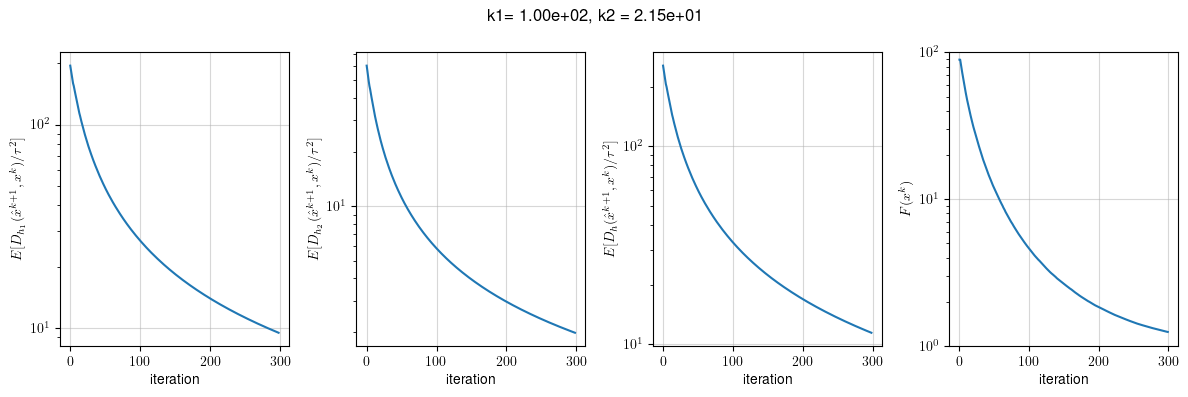

In [5]:
tau = 2e-4
beta = 0.5
SCSC = SCSC_SoR(A, batch_size, x_init, 
                       tau, beta, max_iter, R, lmbda)
SCSC.train()

SCSC.plot(100, 21.5, 0.025, avg=True)